# HCA Adipocytes - Annotation by cell_source

### Owner: Michael Lee

### Input object: hca_heart_global_ctl200422.h5ad

## Last edit date: 200722

## Initialisation and importing of data

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import seaborn as sns
#import scgen
import matplotlib.pyplot as pl
from matplotlib import rcParams

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='RdPu', dpi_save = 260, vector_friendly = True, format = 'svg')
sc.logging.print_versions()

/home/jovyan/my-conda-envs/scanpy1.4.6/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2


In [2]:
def regress_pca(pca, batch):
    regressors = np.zeros(pca.shape, dtype = 'float64')
    regressed = np.zeros(pca.shape, dtype = 'float64')
    for category in np.unique(batch):
        mask = (category == batch)
        regressors[mask,:] = np.mean(pca[mask,:],axis = 0)
    for i in range(pca.shape[1]):
        t = np.c_[np.ones(regressors[:,i].shape),regressors[:,i]]
        b = np.dot(np.dot(np.linalg.inv(np.dot(t.T,t)),t.T),pca[:,i])
        regressed[:,i] = pca[:,i] - b[0] - b[1] * t[:,1]
    return regressed

In [3]:
input_file = './hca_heart_global_ctl200422.h5ad'
results_file = './hca_heart_adipocyte_ctl200422.h5ad'
adata = sc.read(input_file)

In [4]:
adata

AnnData object with n_obs × n_vars = 486134 × 10000 
    obs: 'NRP', 'age_group', 'batch', 'cell_source', 'cell_type', 'donor', 'gender', 'leiden', 'leiden_annotated', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version'
    uns: 'NRP_colors', 'age_group_colors', 'cell_source_colors', 'cell_type_colors', 'donor_colors', 'gender_colors', 'leiden', 'leiden_colors', 'neighbors', 'region_colors', 'type_colors'
    obsm: 'X_pca', 'X_umap'

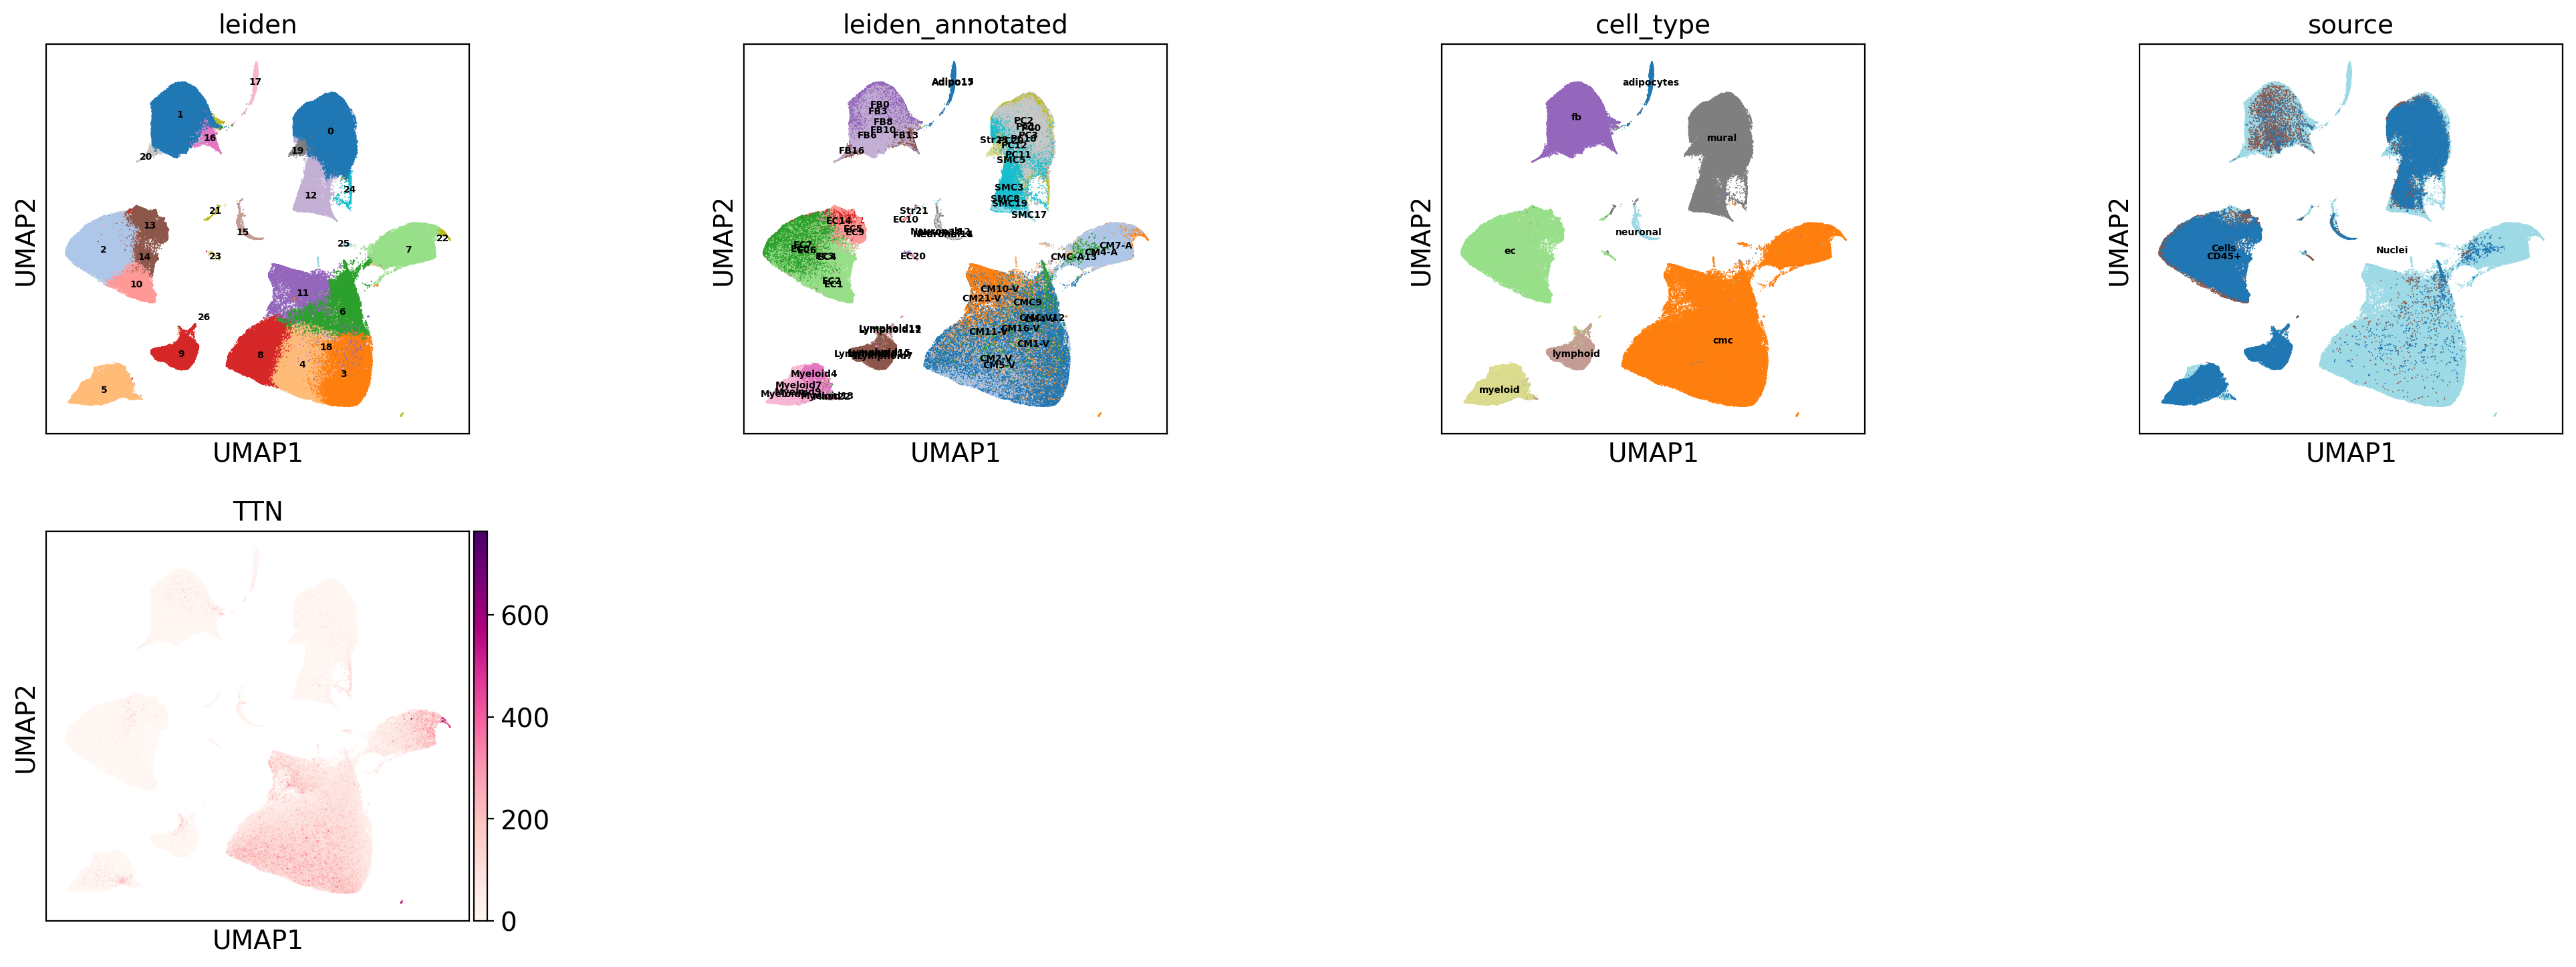

In [72]:
sc.pl.umap(adata, color=['leiden','leiden_annotated','cell_type','source', 'TTN'], wspace = 0.5, size = 2, legend_fontsize = 5, color_map = 'RdPu', palette = 'tab20', legend_loc = 'on data', use_raw=True)

In [6]:
adipo_adata = adata[adata.obs['cell_type'].isin(['adipocytes'])]
adipo_adata.write(results_file)

In [10]:
#results_file = '/hca_heart_adipocyte_ctl200422.h5ad'
#adipo_adata_orig = sc.read(results_file)

In [14]:
adipo_adata = anndata.AnnData(X = adipo_adata_orig.raw.X , obs = adipo_adata_orig.obs, var = adipo_adata_orig.raw.var, obsm = adipo_adata_orig.obsm)
adipo_adata.raw = adipo_adata.copy()

In [15]:
adipo_adata.shape

(3799, 33538)

In [16]:
adipo_adata.raw.shape

(3799, 33538)

In [17]:
adipo_adata

AnnData object with n_obs × n_vars = 3799 × 33538 
    obs: 'NRP', 'age_group', 'batch', 'cell_source', 'cell_type', 'donor', 'gender', 'leiden', 'leiden_annotated', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

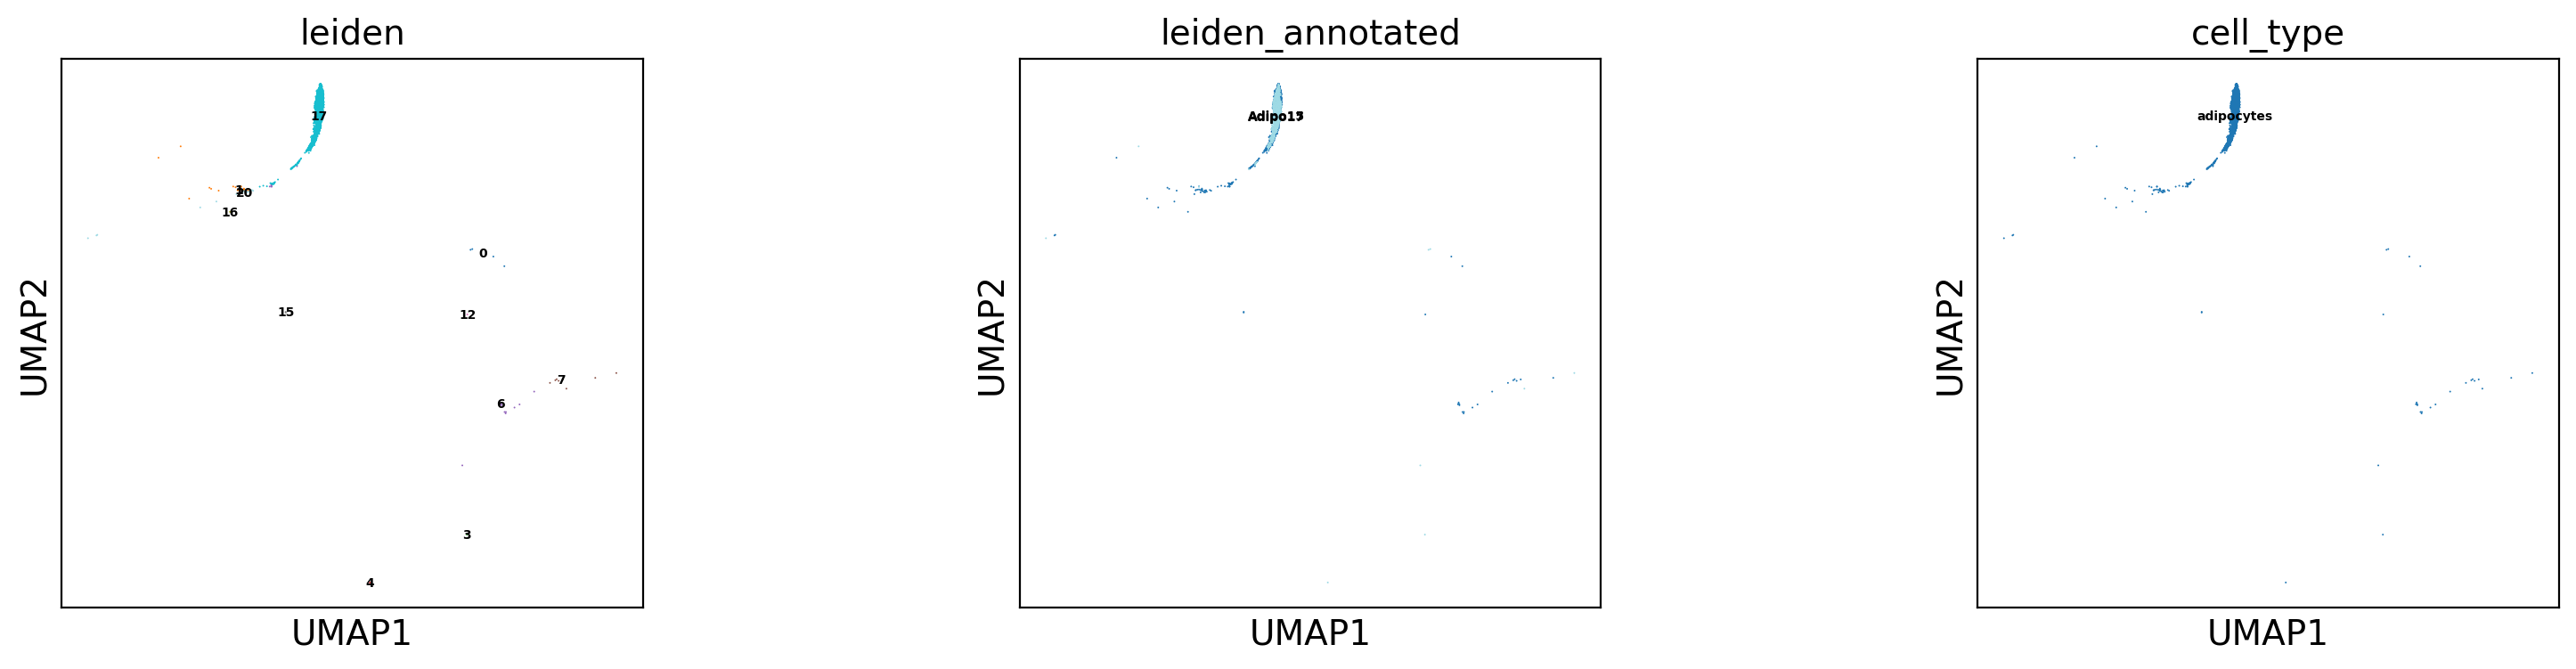

In [18]:
sc.pl.umap(adipo_adata, color=['leiden','leiden_annotated','cell_type'], wspace = 0.5, size = 2, legend_fontsize = 5, color_map = 'RdPu', palette = 'tab20', legend_loc = 'on data')

In [263]:
pd.crosstab(adipo_adata.obs['cell_type'], adipo_adata.obs['leiden_annotated'])

leiden_annotated  Adipo15  Adipo17
cell_type                         
adipocytes           2212     1587

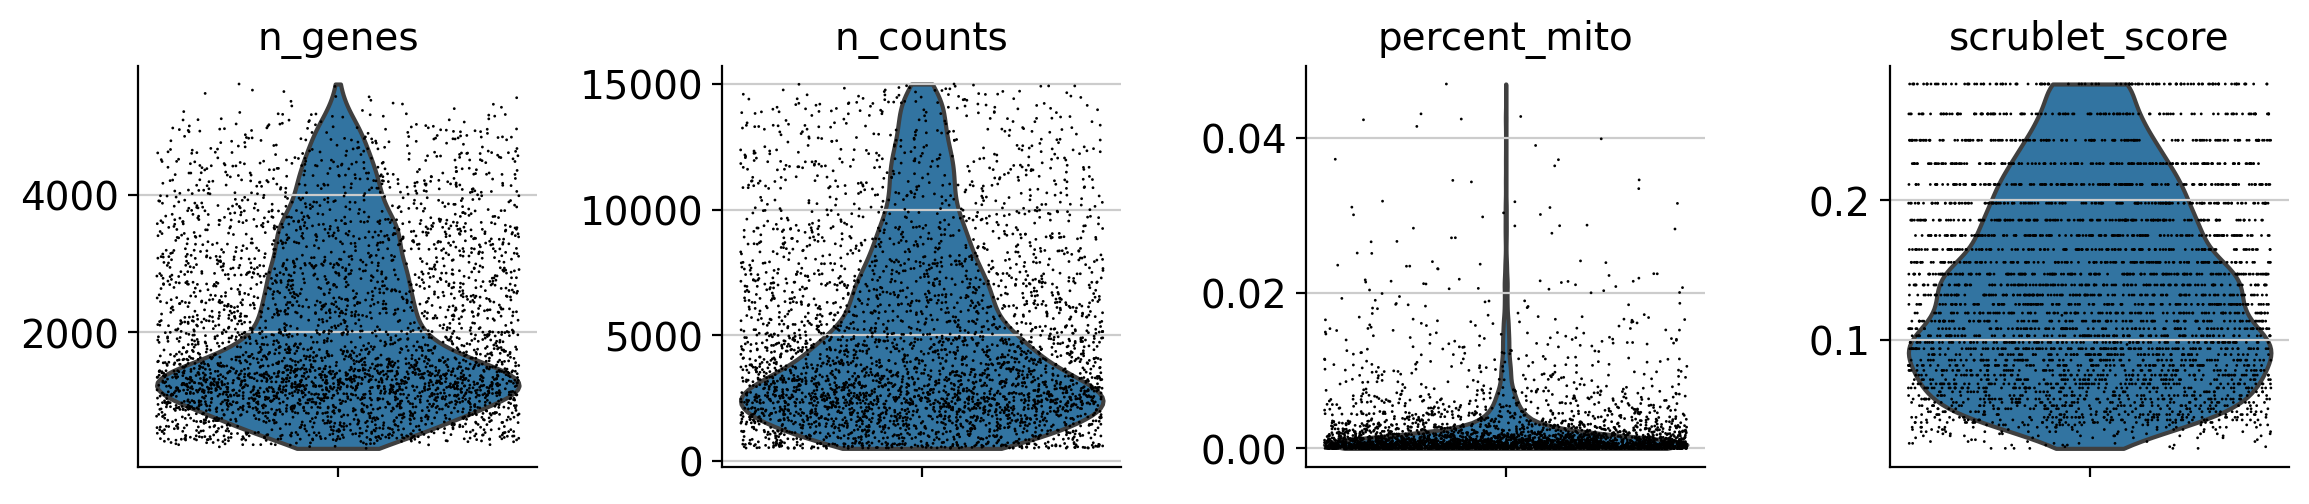

In [19]:
sc.pl.violin(adipo_adata, ['n_genes', 'n_counts', 'percent_mito', 'scrublet_score'],
             jitter=0.4, multi_panel=True
             #, save='_adipo.png'
            )

## Split by sources

In [215]:
adipocytes_sanger = adipo_adata[adipo_adata.obs['cell_source'].isin(['Sanger-Nuclei'])].copy()
adipocytes_harvard = adipo_adata[adipo_adata.obs['cell_source'].isin(['Harvard-Nuclei'])].copy()

In [217]:
adipocytes_sanger.X.max()

4518.0

In [218]:
adipocytes_harvard.X.max()

4658.0

In [219]:
adipocytes_sanger.raw.shape

(1587, 33538)

In [220]:
adipocytes_harvard.raw.shape

(2212, 33538)

## Annotate each source

### Sanger

In [221]:
sanger_bckp = adipocytes_sanger.copy()
sc.pp.normalize_total(adipocytes_sanger, target_sum=1e4)
sc.pp.log1p(adipocytes_sanger)
adipocytes_sanger.raw = adipocytes_sanger

normalizing counts per cell
    finished (0:00:00)


In [222]:
sc.pp.highly_variable_genes(adipocytes_sanger, flavor = 'seurat')
sanger_hvg = adipocytes_sanger[:, adipocytes_sanger.var['highly_variable']]
sc.pp.scale(sanger_hvg, max_value = 10)
sanger_hvg.shape

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jovyan/my-conda-envs/scanpy1.4.6/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


(1587, 5288)

In [223]:
sc.tl.pca(sanger_hvg, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(sanger_hvg, random_state = 1712)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [224]:
sanger_hvg.obsm['X_pca_original'] = sanger_hvg.obsm['X_pca'].copy()
sanger_hvg.obsm['X_pca'] = regress_pca(sanger_hvg.obsm['X_pca'], sanger_hvg.obs['donor'])

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


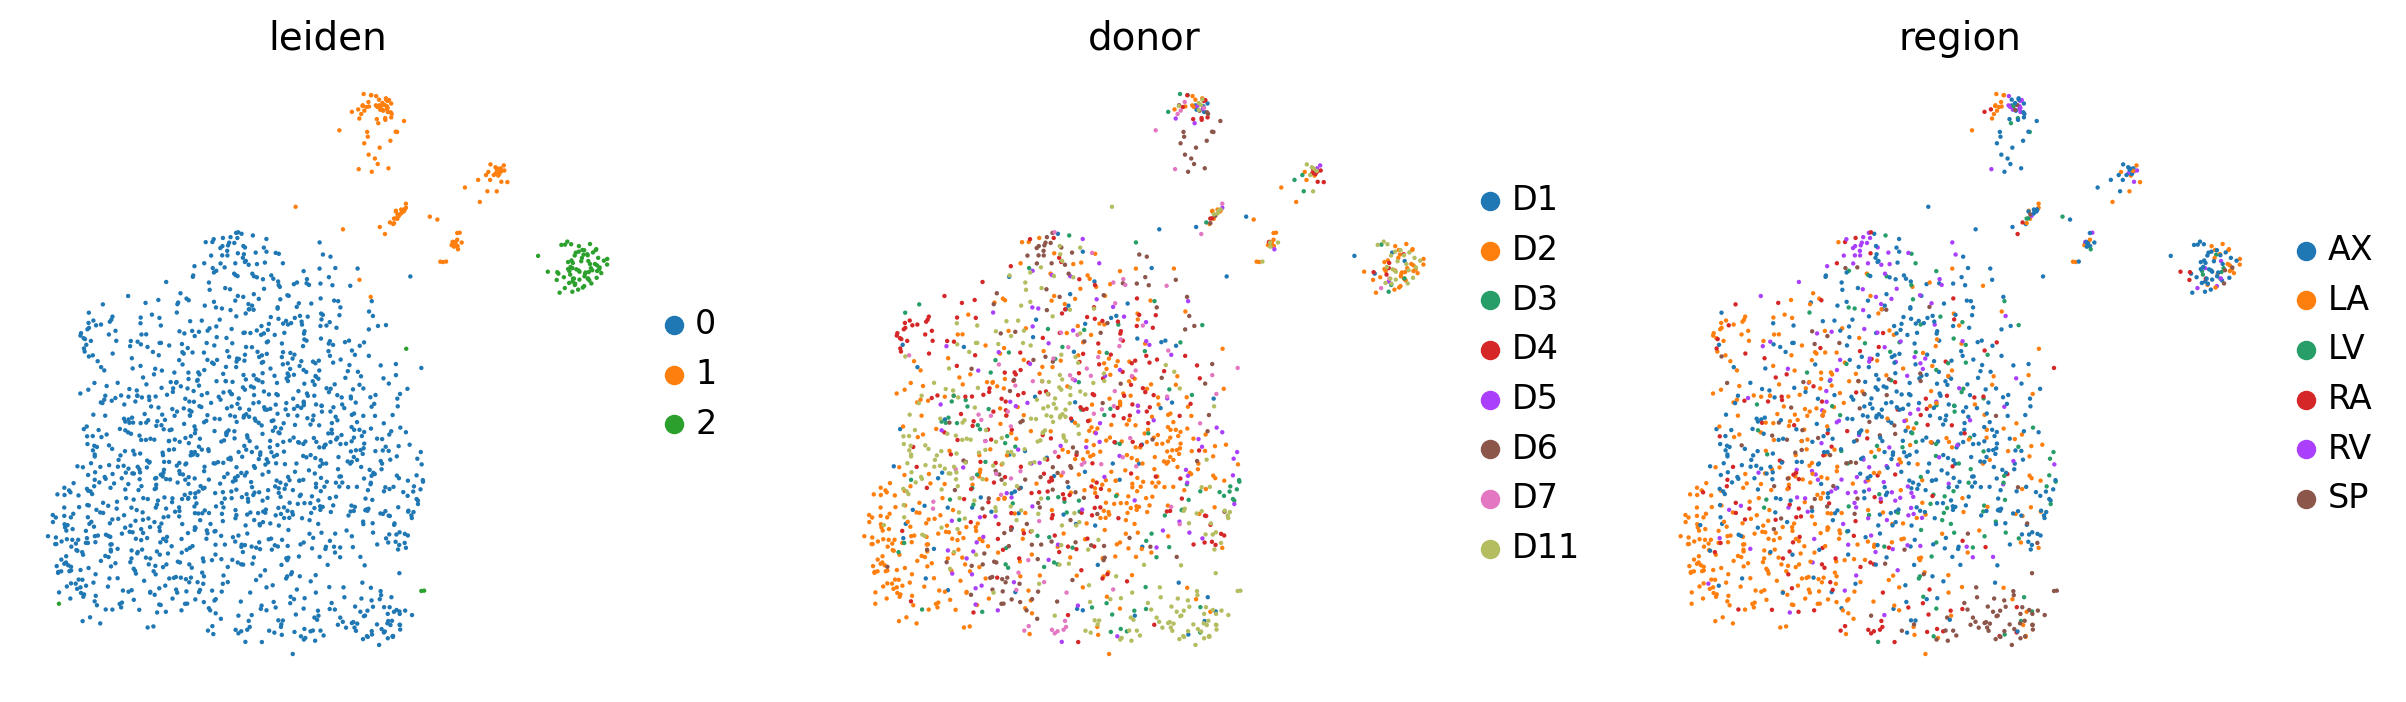

In [225]:
sanger_bbknn = bbknn.bbknn(sanger_hvg, neighbors_within_batch = 6, batch_key = 'donor', n_trees = 100, copy = True)
#sanger_bbknn.uns['leiden_colors'] = sanger_bbknn.uns['region_colors']
sc.tl.umap(sanger_bbknn, min_dist = 0.2, spread = 2, random_state = 100)
sc.tl.leiden(sanger_bbknn, resolution = 0.4, random_state = 1786)
sc.pl.umap(sanger_bbknn, color = ['leiden', 'donor', 'region'], size = 10, legend_fontsize = 12, frameon = False)

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


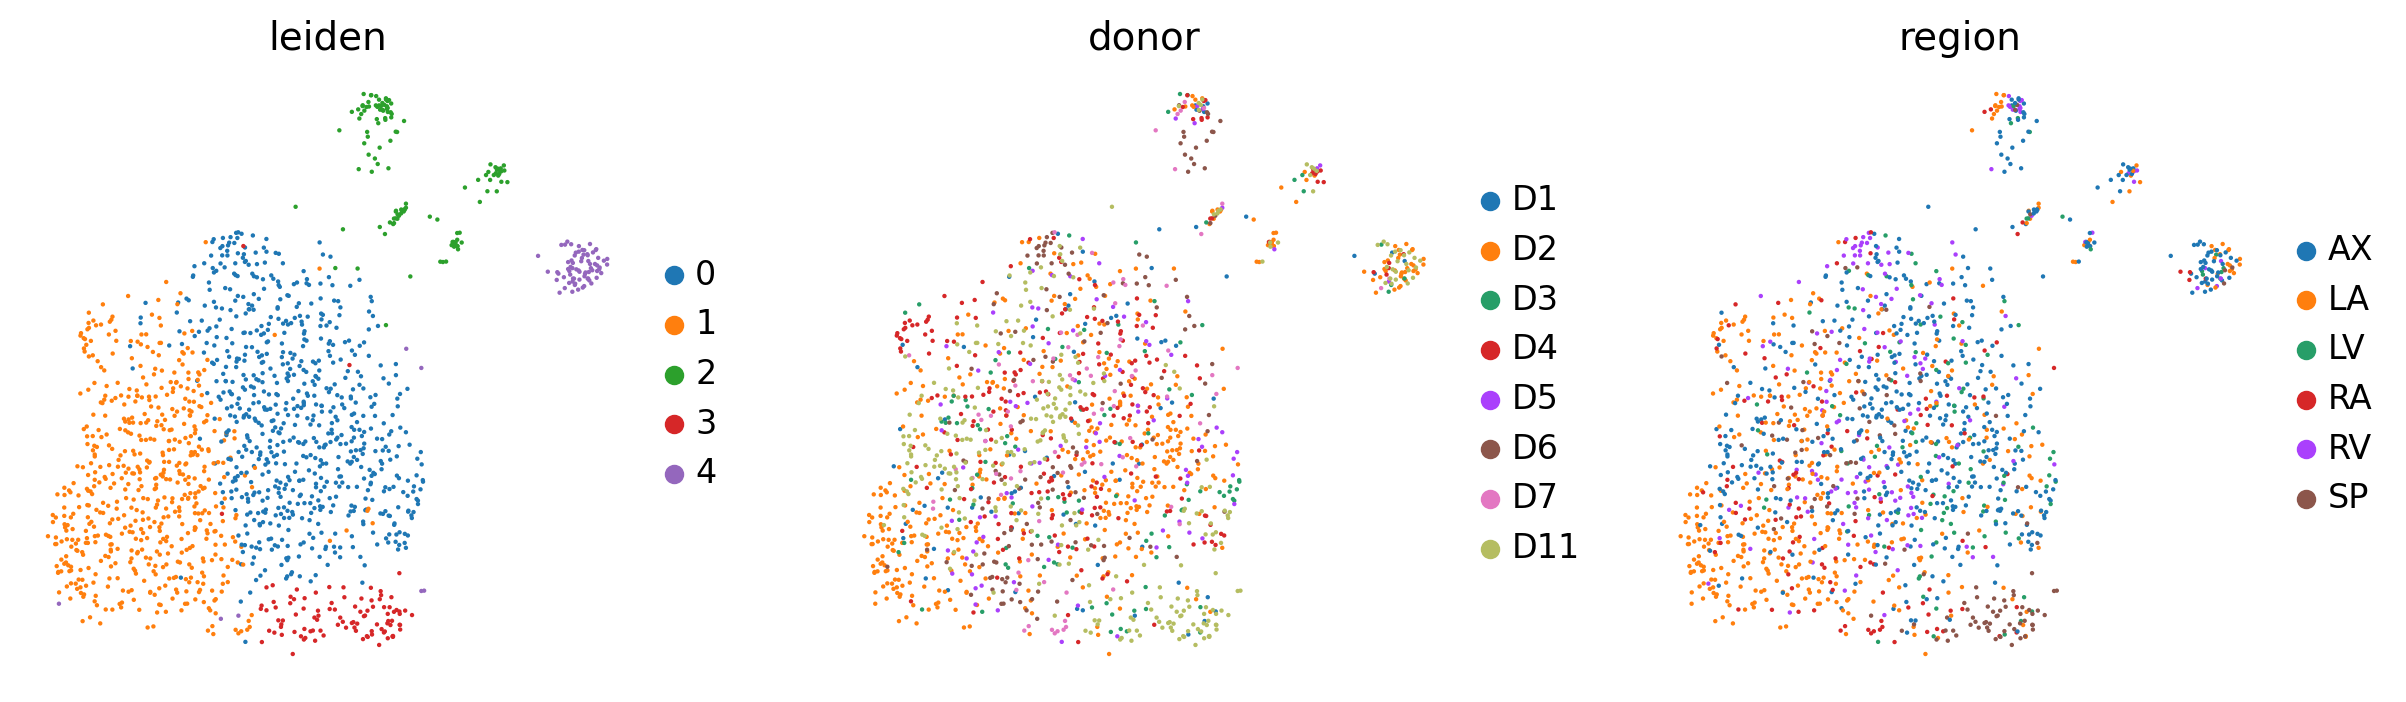

In [226]:
sc.tl.leiden(sanger_bbknn, resolution = 0.63, random_state = 1786)
sc.pl.umap(sanger_bbknn, color = ['leiden', 'donor', 'region'], size = 10, legend_fontsize = 12, frameon = False)

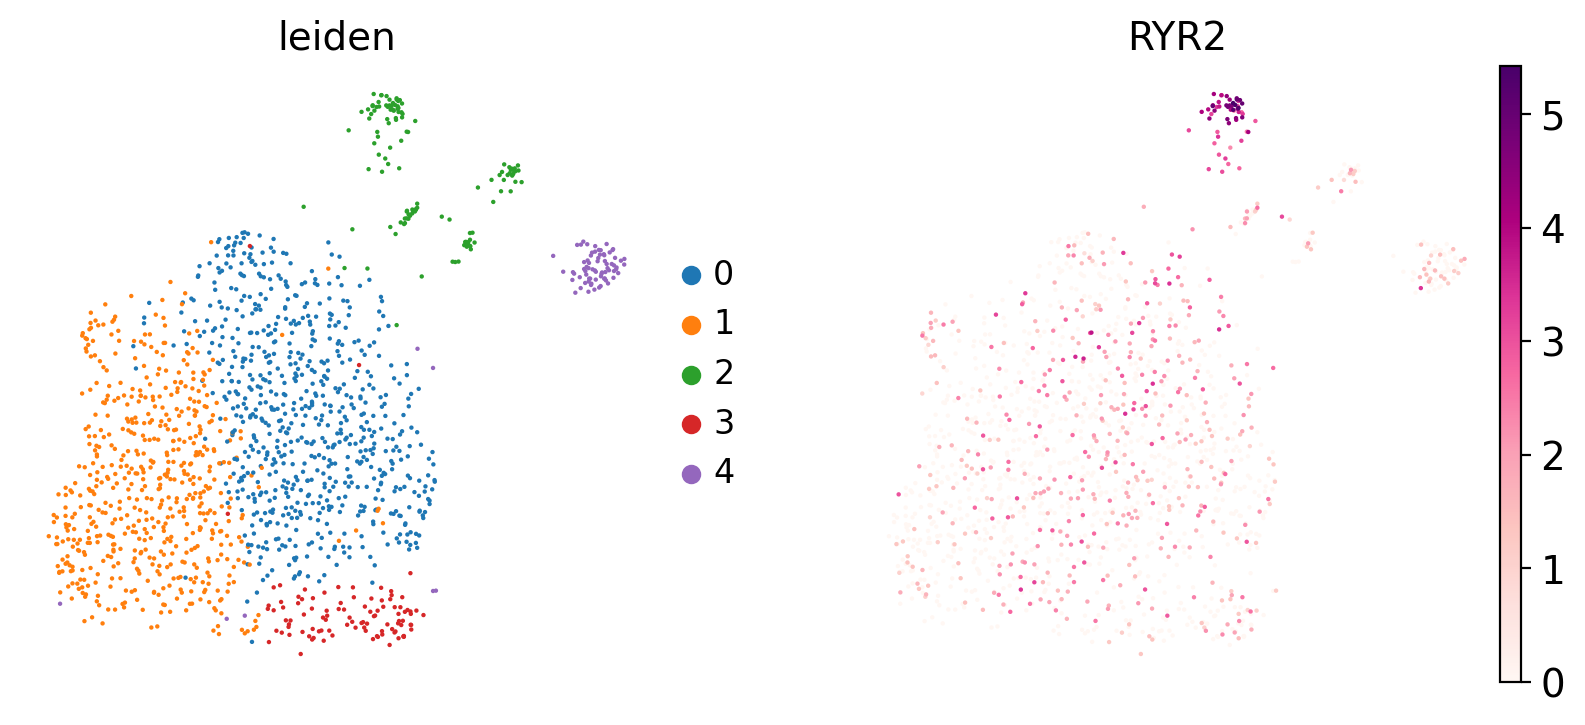

In [227]:
sc.pl.umap(sanger_bbknn, color = ['leiden', 'RYR2'], size = 10, legend_fontsize = 12, frameon = False, use_raw=True)

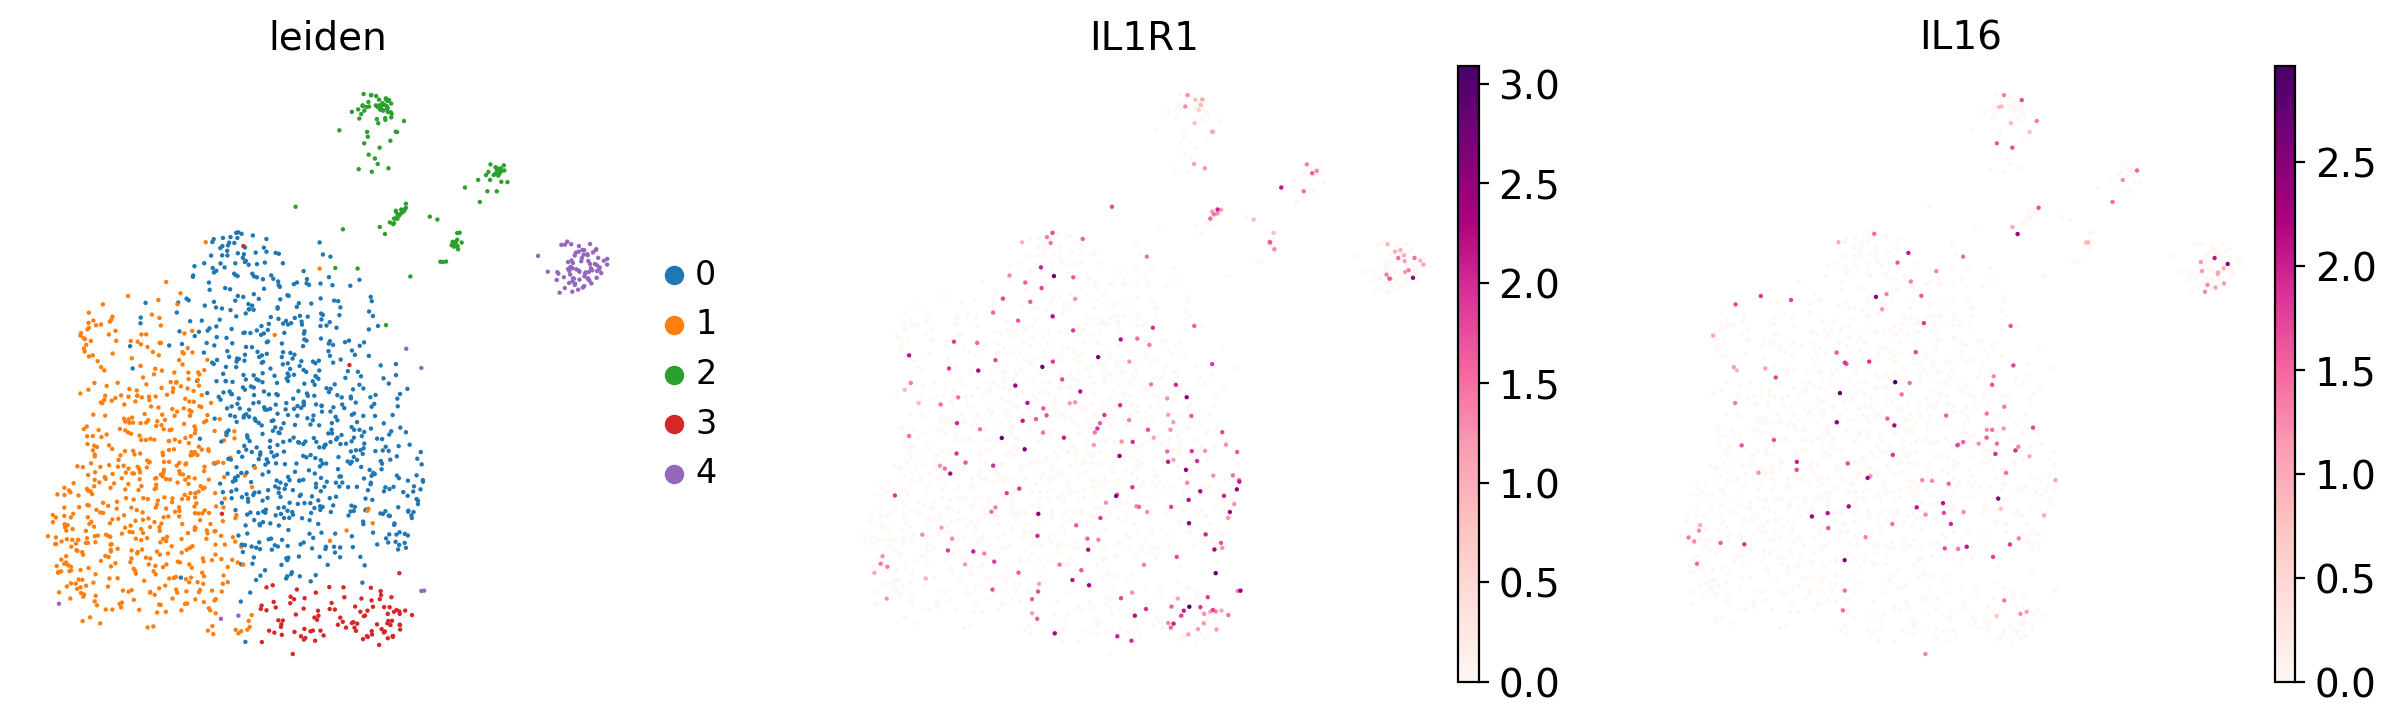

In [228]:
sc.pl.umap(sanger_bbknn, color = ['leiden', 'IL1R1','IL16'], size = 10, legend_fontsize = 12, frameon = False, use_raw=True)

In [229]:
sanger_bbknn.obs['leiden'].value_counts()

0    701
1    581
2    126
3    100
4     79
Name: leiden, dtype: int64

In [230]:
sc.tl.rank_genes_groups(sanger_bbknn, 'leiden', method = 'wilcoxon', n_genes = 500, use_raw = True)
result = sanger_bbknn.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers_sanger = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','scores', 'pvals_adj', 'logfoldchanges']})
markers_sanger.head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


0_n       0_s           0_p       0_l     1_n        1_s           1_p  \
0   LAMA4  8.874251  1.816344e-15  0.908115   ACSS2  13.852811  4.102688e-39   
1   FABP4  7.717223  1.993697e-11  0.852118   ACACA  13.760596  7.376388e-39   
2    G0S2  7.593627  4.967963e-11  0.765667  ELOVL6  12.339629  6.194523e-31   
3    DLC1  7.552374  6.515443e-11  0.487376    FASN  12.095164  9.392161e-30   
4   PLIN1  7.315387  3.586344e-10  0.659163    ACLY  11.286780  1.023051e-25   
5    MEST  6.666416  3.031440e-08  0.870498     ME1  11.211849  1.993623e-25   
6  TGFBR3  6.574809  5.446095e-08  0.745979    AACS  11.124808  4.552052e-25   
7    TNS1  6.540284  6.642928e-08  0.691244     SCD  10.874033  6.425576e-24   
8     DPT  6.239707  4.084113e-07  1.587862    GPAM  10.582494  1.338783e-22   
9    EBF1  6.104860  8.388003e-07  0.394087    GRK3   9.941882  9.176286e-20   

        1_l      2_n       2_s           2_p       2_l       3_n        3_s  \
0  1.666119    PRKG1  9.958248  7.784748e-19  3.028223   GADD45B  12.251618   
1  1.578012  CACNA1C  9.481715  4.194532e-17  3.550736     NAMPT  12.176663   
2  2.615867    PDE3A  9.267357  1.529773e-16  3.350334    SLC1A3  11.962731   
3  1.413833   SLC8A1  9.265128  1.529773e-16  3.025815     SOCS3  11.096519   
4  1.837086      TTN  9.248312  1.529773e-16  3.126387     ZFP36  10.971857   
5  1.711586    FGF12  9.129483  3.847213e-16  3.366672     ABCA1  10.925982   
6  1.740811     RYR2  8.220181  9.735378e-13  3.039525  CDC42EP4  10.491468   
7  1.554676   CTNNA3  8.193741  1.061599e-12  3.149244     CCNL1  10.426432   
8  1.009311     TPM1  8.079268  2.428024e-12  2.277437    CDKN1A  10.231548   
9  1.231331     LDB3  8.062148  2.514190e-12  3.515812       LBP  10.104519   

            3_p       3_l     4_n        4_s           4_p       4_l  
0  5.522928e-30  3.542125   LAMA2  13.159189  5.053966e-35  4.294010  
1  6.940203e-30  3.573695   NEGR1  11.557641  1.132552e-26  4.815236  
2  6.226828e-29  2.904733     DCN  10.896017  1.346139e-23  3.687391  
3  1.093541e-24  3.862866   PRKG1   9.869204  3.952953e-19  3.396328  
4  3.500634e-24  3.045755  IGFBP7   9.865173  3.952953e-19  3.454030  
5  4.840533e-24  2.758545   CDH19   9.687238  1.909674e-18  5.806944  
6  4.529913e-22  3.223164    RORA   9.532095  7.385109e-18  2.581530  
7  7.873415e-22  2.845810   BICC1   9.484746  1.018608e-17  3.901357  
8  5.336674e-21  3.811374   DCLK1   9.331492  3.890067e-17  5.186386  
9  1.769253e-20  4.446989   ABCA8   8.675409  1.381991e-14  3.051238

In [231]:
sc.tl.dendrogram(sanger_bbknn, groupby='leiden', use_raw=True)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


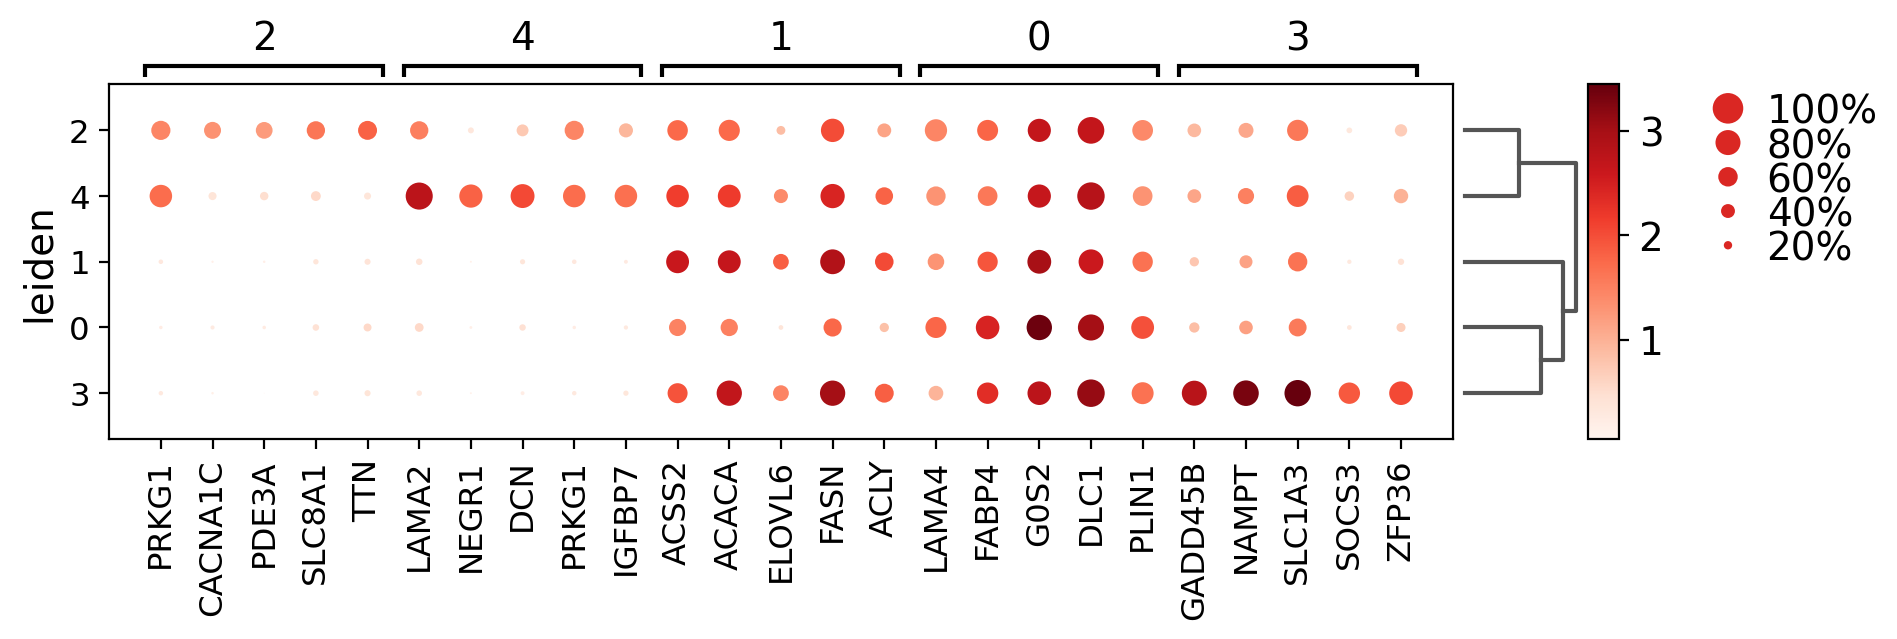

In [232]:
sc.pl.rank_genes_groups_dotplot(sanger_bbknn, key='rank_genes_groups', n_genes=5, use_raw=True)

In [233]:
markers_sanger.to_csv('./heart_adipocytes_sanger-nuclei_wilcox_ctl200422_ml200501.tsv', sep = '\t', index = False)

In [234]:
sanger_bbknn.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4'], dtype='object')

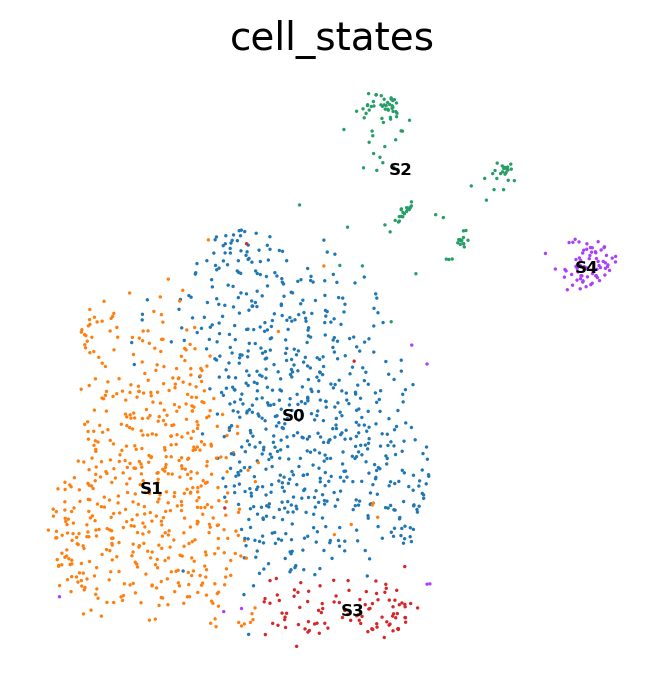

In [235]:
sanger_bbknn.obs['cell_states'] = sanger_bbknn.obs['leiden']
sanger_bbknn.obs['cell_states'].cat.categories = ['S0', 'S1', 'S2', 'S3', 'S4']
sc.pl.umap(sanger_bbknn, color = ['cell_states'], size = 6, legend_fontsize = 6, legend_loc = 'on data', frameon = False)

In [236]:
sanger_bbknn_raw = anndata.AnnData(X = sanger_bckp.X , obs = sanger_bbknn.obs, var = sanger_bckp.var, obsm = sanger_bbknn.obsm)
sanger_bbknn_raw.raw = sanger_bckp.copy()
sanger_bbknn_raw.write('./heart_sanger_adipocytes_nuclei_annotated_ctl200422_ml200501.h5ad')

In [261]:
sanger_bbknn_raw.X.max()

4518.0

### Harvard

In [237]:
harvard_bckp = adipocytes_harvard.copy()
sc.pp.normalize_total(adipocytes_harvard, target_sum=1e4)
sc.pp.log1p(adipocytes_harvard)
adipocytes_harvard.raw = adipocytes_harvard

normalizing counts per cell
    finished (0:00:00)


In [238]:
sc.pp.highly_variable_genes(adipocytes_harvard, flavor = 'seurat')
harvard_hvg = adipocytes_harvard[:, adipocytes_sanger.var['highly_variable']]
sc.pp.scale(harvard_hvg, max_value = 10)
harvard_hvg.shape

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jovyan/my-conda-envs/scanpy1.4.6/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


(2212, 5288)

In [239]:
sc.tl.pca(harvard_hvg, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(harvard_hvg, random_state = 1712)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [240]:
harvard_hvg.obsm['X_pca_original'] = harvard_hvg.obsm['X_pca'].copy()
harvard_hvg.obsm['X_pca'] = regress_pca(harvard_hvg.obsm['X_pca'], harvard_hvg.obs['donor'])

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


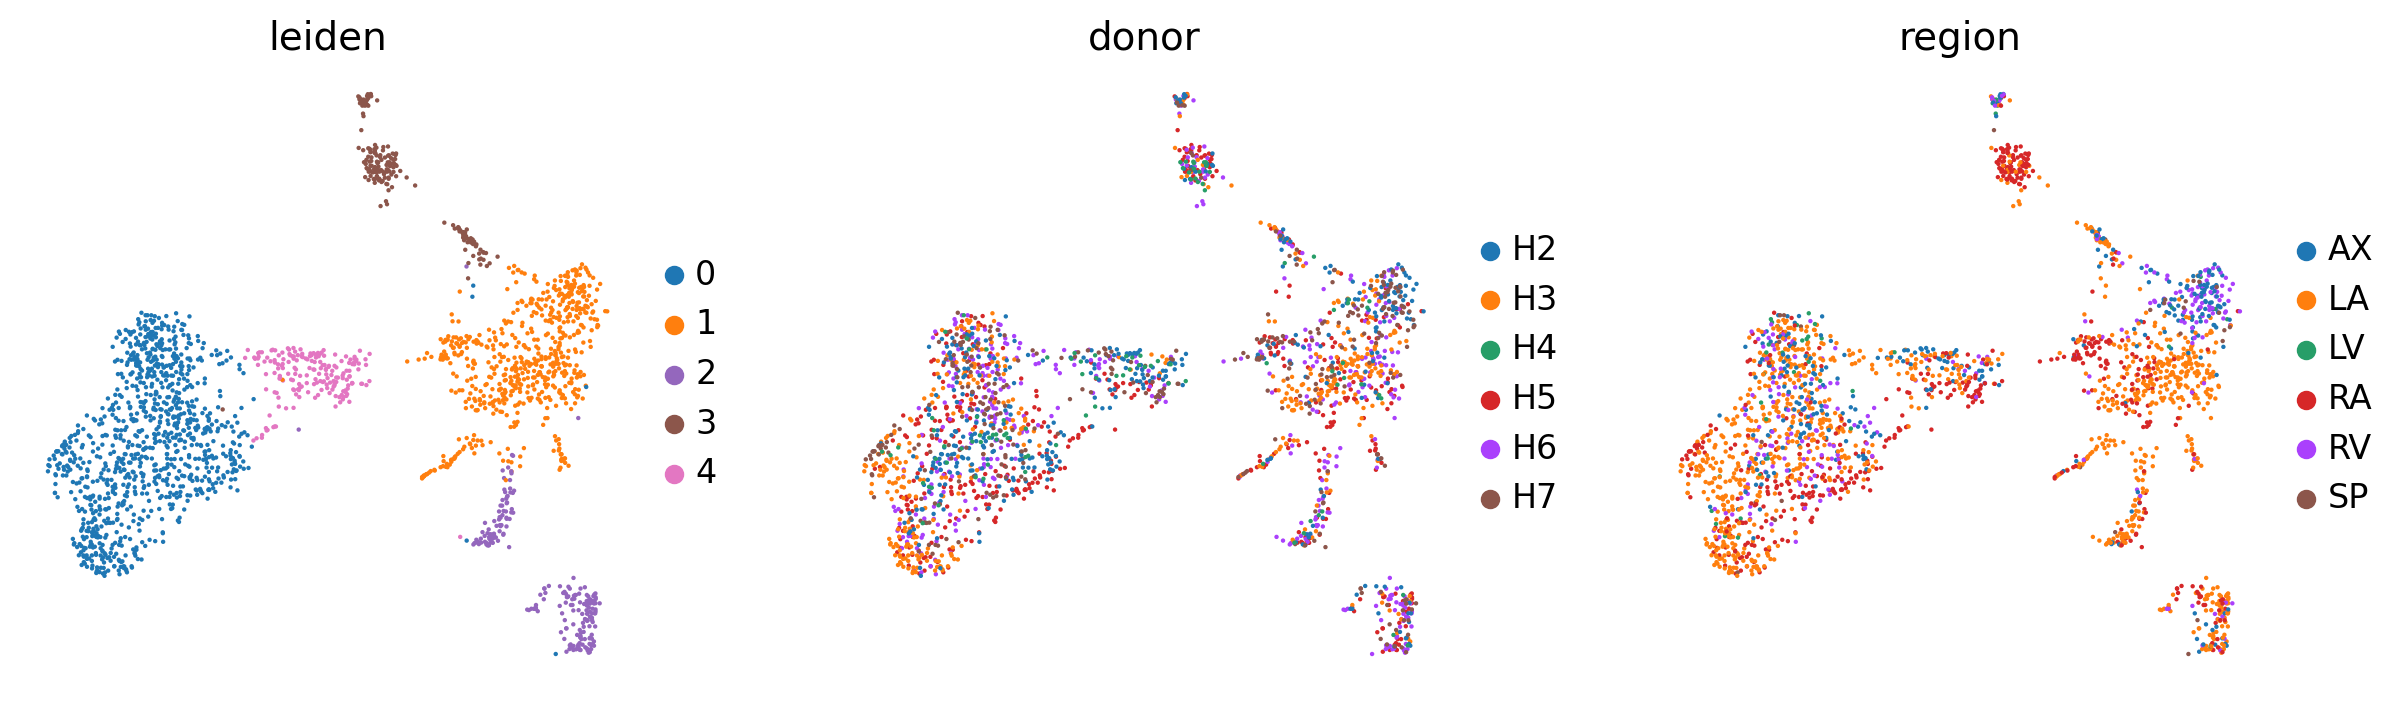

In [241]:
harvard_bbknn = bbknn.bbknn(harvard_hvg, neighbors_within_batch = 3, batch_key = 'donor', n_trees = 100, copy = True)
sc.tl.umap(harvard_bbknn, min_dist = 0.2, spread = 2, random_state = 1712)
sc.tl.leiden(harvard_bbknn, resolution = 0.3, random_state = 1786)
sc.pl.umap(harvard_bbknn, color = ['leiden', 'donor', 'region'], size = 10, legend_fontsize = 12, color_map = 'RdPu', frameon = False)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


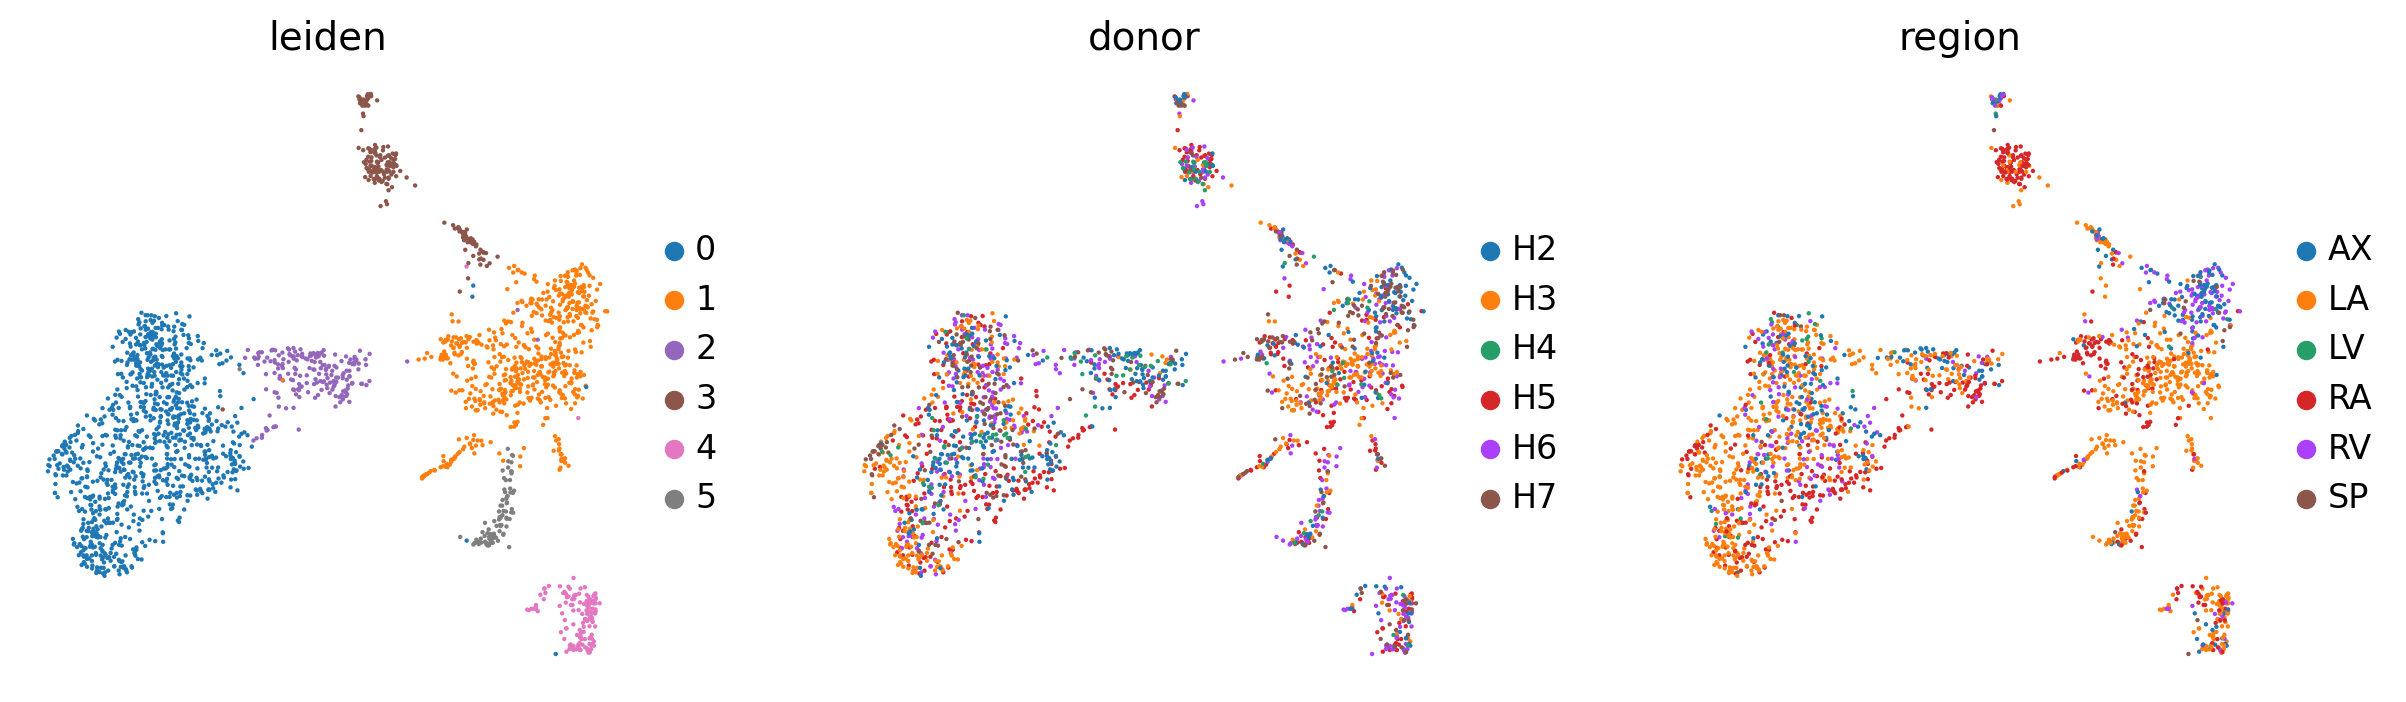

In [250]:
sc.tl.leiden(harvard_bbknn, resolution = 0.4, random_state = 1786)
sc.pl.umap(harvard_bbknn, color = ['leiden', 'donor', 'region'], size = 10, legend_fontsize = 12, color_map = 'RdPu', frameon = False)

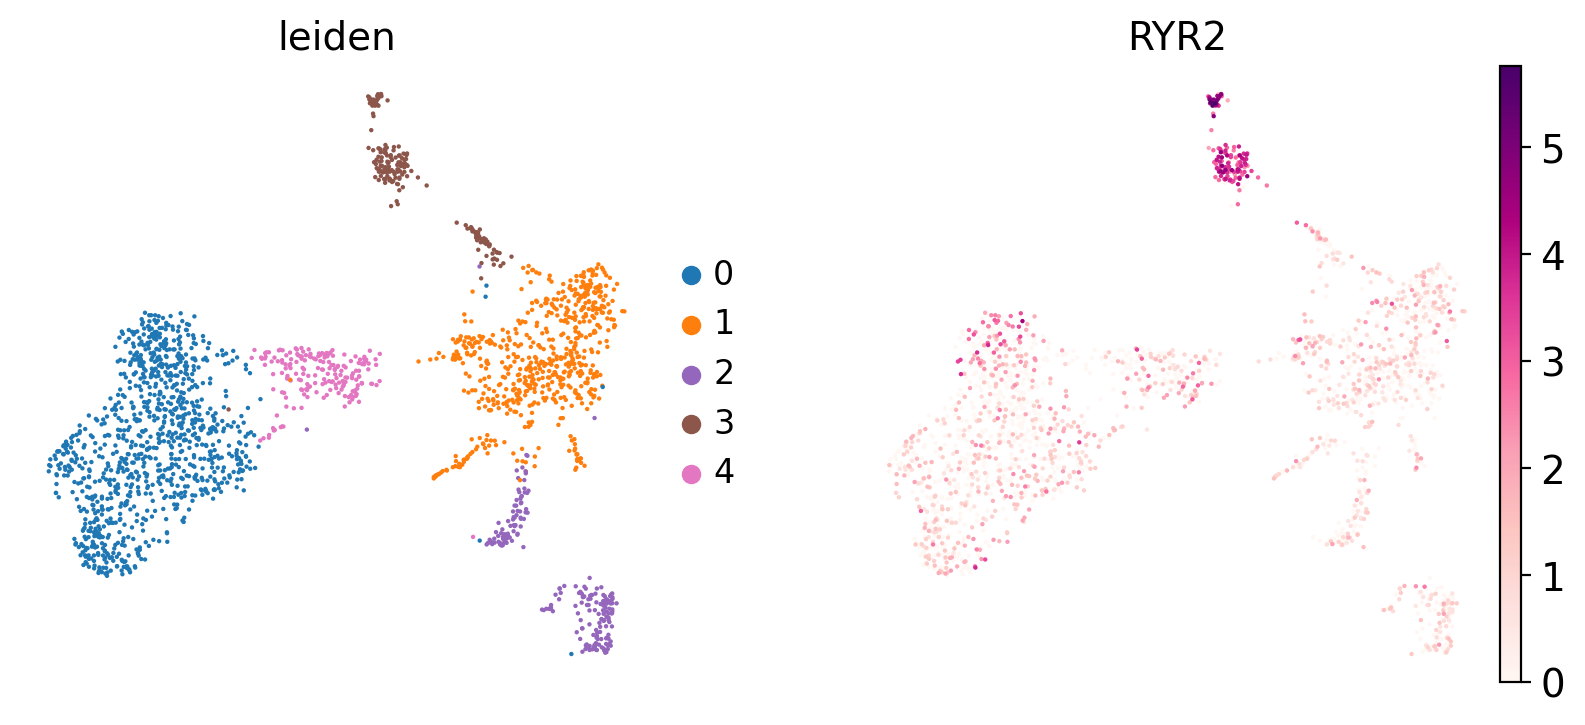

In [243]:
sc.pl.umap(harvard_bbknn, color = ['leiden', 'RYR2'], size = 10, legend_fontsize = 12, color_map = 'RdPu', frameon = False, use_raw=True)

In [251]:
sc.tl.rank_genes_groups(harvard_bbknn, 'leiden', method = 'wilcoxon', n_genes = 500, use_raw = True)
result = harvard_bbknn.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers_harvard = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
markers_harvard.head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


0_n           0_p       0_l    1_n            1_p       1_l  \
0       ACACB  6.369899e-87  1.397868  NEGR1  2.479245e-184  3.883989   
1        AQP7  6.998747e-70  1.175312  LAMA2  2.479245e-184  3.617155   
2     PRKAR2B  7.099225e-59  1.414739  CDH19  1.771249e-178  4.314184   
3       ACSL1  1.314376e-58  1.042962  ABCA8  8.194406e-150  3.052287   
4       PDE3B  1.335236e-56  1.037031  BICC1  1.631409e-147  3.418574   
5    LIPE-AS1  2.065317e-56  1.097873    DCN  1.298746e-145  3.245313   
6       PLIN1  3.475823e-43  0.833680  ABCA9  1.156308e-141  2.959637   
7         LPL  1.420092e-42  1.082230  DCLK1  2.720111e-140  3.454982   
8  AL845331.2  2.297088e-40  1.201093  FBXL7  4.459899e-137  2.903418   
9       PPARG  1.813945e-38  1.006567   PID1  9.343955e-135  2.770080   

        2_n           2_p       2_l      3_n           3_p       3_l     4_n  \
0      MT2A  2.655750e-62  3.678250      TTN  1.320311e-42  3.753430    MRC1   
1     NAMPT  4.928898e-56  2.957873   MYBPC3  1.320311e-42  4.760261   CD163   
2      MT1X  2.618000e-48  2.742995     RYR2  2.127939e-41  3.742055   F13A1   
3     STAT3  7.704328e-46  2.071608    ACTC1  7.161717e-34  3.894428    RBPJ   
4  CDC42EP4  1.060851e-43  2.993039   ANKRD1  1.578977e-31  4.101022    FMN1   
5  SLC39A14  8.276992e-43  3.052862    TNNT2  1.182598e-29  3.996825  FRMD4B   
6      SAA1  2.846860e-41  3.450605     TPM1  3.627583e-26  2.968430  TBXAS1   
7      MT1M  9.328374e-40  3.135182    CALD1  5.757040e-24  1.790487   DOCK2   
8    SLC1A3  7.354757e-38  1.941176  CACNA1C  5.995783e-24  3.242675   RBM47   
9     SOCS3  9.354834e-38  3.250610     MYL7  1.278428e-23  4.080039   ELMO1   

            4_p       4_l         5_n           5_p       5_l  
0  7.843656e-43  6.325688  ST6GALNAC3  1.193022e-34  5.081644  
1  6.501148e-42  6.042070        LDB2  1.940212e-33  4.318750  
2  7.982524e-42  5.910749         VWF  1.322023e-29  4.716112  
3  3.459234e-40  3.414983        ANO2  5.265373e-29  5.436670  
4  4.419207e-40  4.907184     PITPNC1  1.092699e-26  2.834599  
5  1.256547e-39  3.679707       PTPRB  5.303837e-25  5.498920  
6  9.414931e-38  4.011580       EGFL7  2.819426e-24  4.507854  
7  3.300290e-37  5.144763        EMCN  1.013152e-22  4.842350  
8  4.378334e-37  3.539898       ELMO1  6.191020e-22  2.853718  
9  2.955507e-35  3.022230      PECAM1  6.191020e-22  4.141799

In [252]:
sc.tl.dendrogram(harvard_bbknn, groupby='leiden', use_raw=True)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


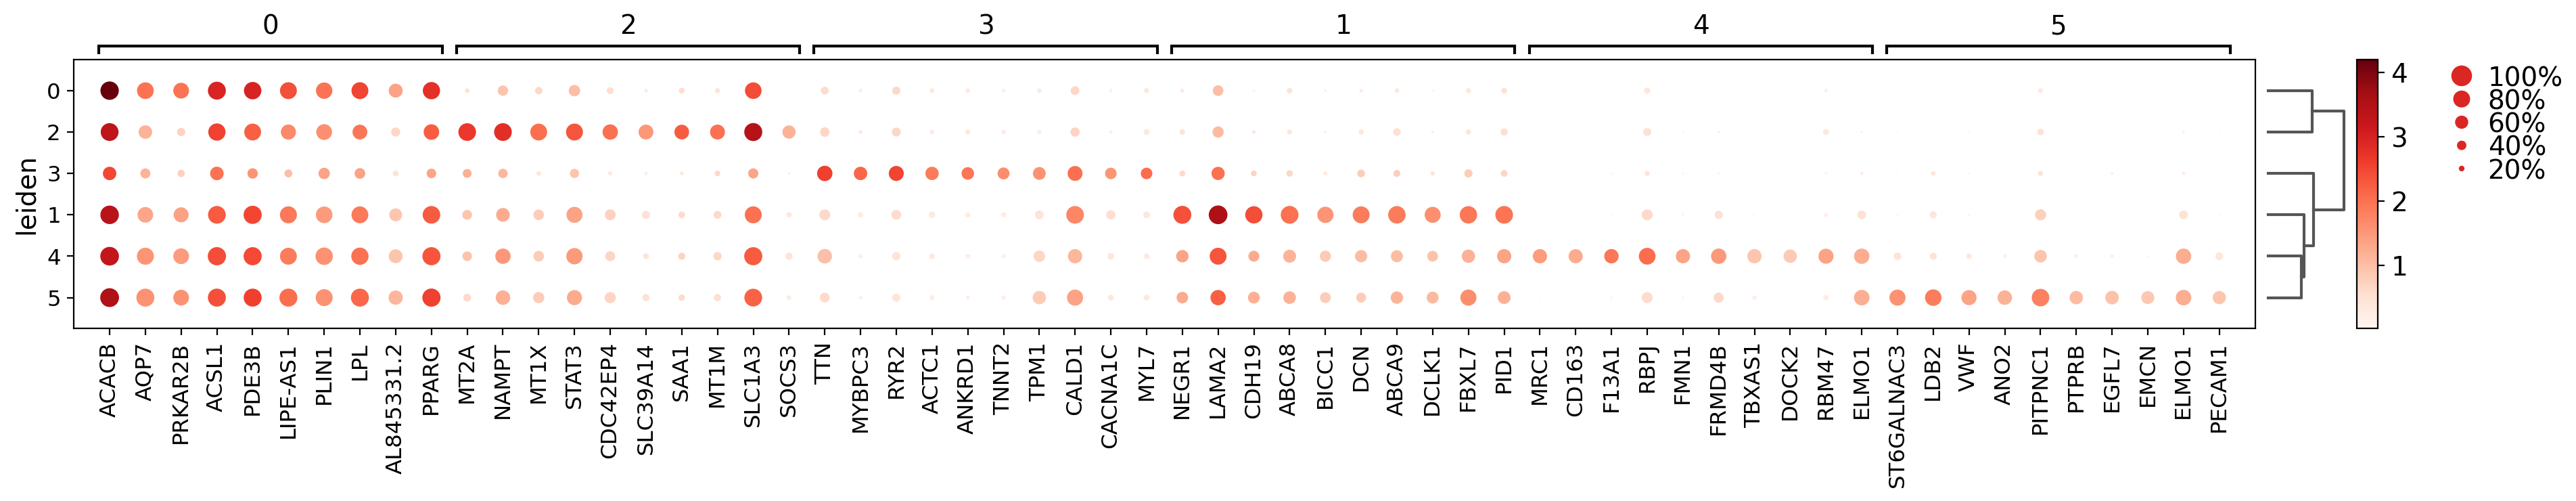

In [253]:
sc.pl.rank_genes_groups_dotplot(harvard_bbknn, key='rank_genes_groups', n_genes=10)

In [254]:
markers_harvard.to_csv('./heart_adipocytes_harvard-nuclei_wilcox_ctl200422_ml200501.tsv', sep = '\t', index = False)

In [255]:
harvard_bbknn.obs['leiden'].cat.categories

Index(['0', '1', '2', '3', '4', '5'], dtype='object')

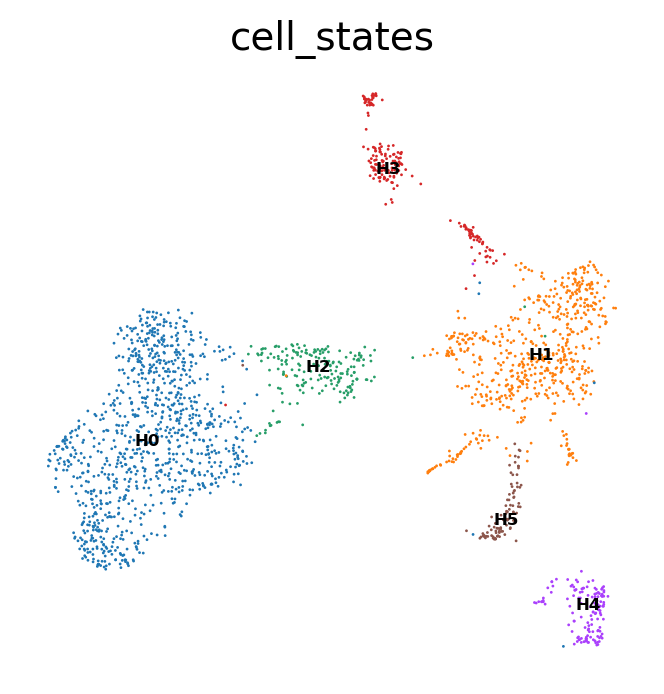

In [256]:
harvard_bbknn.obs['cell_states'] = harvard_bbknn.obs['leiden']
harvard_bbknn.obs['cell_states'].cat.categories = ['H0', 'H1', 'H2', 'H3','H4','H5']
sc.pl.umap(harvard_bbknn, color = ['cell_states'], size = 4, legend_fontsize = 6, legend_loc = 'on data', frameon = False)

In [257]:
harvard_bbknn_raw = anndata.AnnData(X = harvard_bckp.X , obs = harvard_bbknn.obs, var = harvard_bckp.var, obsm = harvard_bbknn.obsm)
harvard_bbknn_raw.raw = harvard_bckp.copy()
harvard_bbknn_raw.write('./heart_harvard_adipocytes_nuclei_annotated_ctl200422_ml200501.h5ad')

In [259]:
harvard_bbknn_raw.X.max()

4658.0